# Load the data in the form of a dictionary

# The dictionary has different keys
- DESCR:  describes the dataset
- data: array of data (one row per instance, one column per feature)
- target: array of labels
...

In [33]:
!pip install scikit-learn
!pip install pandas
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1) # Returns a dictionary with the data
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

# Get the data and labels

In [34]:

import numpy as np
X, y = mnist["data"], mnist["target"]
y = y.astype(int) # Convert y to list of integers
X = ((X/255.) - .5)*2
print(X.shape, y.shape)
print(min(y),max(y))
print(type(X), type(y))
print(np.min(np.min(X,axis=0),axis=0),np.max(np.max(X,axis=0)))

(70000, 784) (70000,)
0 9
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>
-1.0 1.0


# Visualize the data

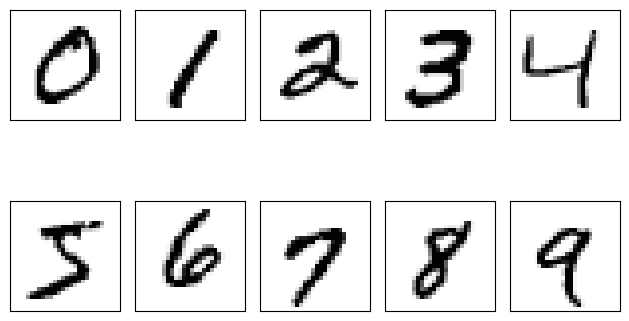

In [35]:
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=5,sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    matchlist = [i for i, x in enumerate(y == i) if x]
    img = X.loc[matchlist[0]].to_numpy().reshape(28,28)
    ax[i].imshow(img,cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

# Divide the data into training, development and testing sets

In [36]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(min(y_train),max(y_train))
print(min(y_test),max(y_test))
X_test = X_test.to_numpy()
y_test  = y_test .to_numpy()

(60000, 784) (10000, 784) (60000,) (10000,)
0 9
0 9


In [37]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter=StratifiedShuffleSplit(n_splits=1,random_state=12)
for train,test in splitter.split(X_train,y_train):
    X_train_strat = X_train.iloc[train]
    y_train_strat  = y_train.iloc[train]
    X_dev_strat= X_train.iloc[test]
    y_dev_strat = y_train.iloc[test]
X_train_strat = X_train_strat.to_numpy()
y_train_strat = y_train_strat.to_numpy()
X_dev_strat = X_dev_strat.to_numpy()
y_dev_strat = y_dev_strat.to_numpy()
#print(X_train_strat.shape, y_train_strat.shape, X_dev_strat.shape, y_dev_strat.shape)
#print(min(y_train_strat),max(y_train_strat))
#print(min(y_dev_strat),max(y_dev_strat))


# Use the dataloader to automatically divide data into batches

In [38]:
# Import key libraries
import torch
import torch.nn as nn
import torch.nn.functional as Func
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data as data
import random
from scipy.io import savemat
import os
from os import path
from sklearn.preprocessing import normalize
from torch.nn.utils import clip_grad_norm_
import torch.nn.parallel.data_parallel as data_parallel
from sklearn.metrics import confusion_matrix

In [39]:
# Define key hyperparameters
class hyperparam:
    num_classes    = 10 # 10 neurons for the output layer
    input_dim      = 28*28 # Inputs are size 28x28
    lr          = 0.05 # Initial learning rate
    num_epochs = 100 # Number of epochs
    bs          = 50 # Mini-batch size


In [40]:
class myDataset(data.Dataset):
    def __init__(self, input_data, labels):
        # Initialize variables
        self.feats = input_data
        self.labels = labels

    def __len__(self):
        return len(self.labels) # returns the number of samples

    def __getitem__(self, index): # Returns sample data and label
        # Reshaping inputs to size 28x28
        X = self.feats[index].reshape(28, 28)
        X = X[np.newaxis, :, :]
        X = torch.tensor(X, dtype = torch.float32)
        y = torch.tensor(self.labels[index], dtype=torch.long)
        return X, y


In [41]:
params = {'batch_size': hyperparam.bs,
         'shuffle': True,
         'num_workers': 0,
         'drop_last': False,
         'pin_memory': False}

training_set = myDataset(X_train_strat,y_train_strat)
dev_set      = myDataset(X_dev_strat,y_dev_strat)
test_set     = myDataset(X_test,y_test)

training_gen = data.DataLoader(training_set,**params)
dev_gen      = data.DataLoader(dev_set,**params)

params2 = {'batch_size': 16,
         'shuffle': False,
         'num_workers': 0,
         'drop_last': False,
         'pin_memory': False}
testing_gen  = data.DataLoader(test_set,**params2)
print(X_train_strat.shape)

(54000, 784)


In [42]:
import torch.nn.functional as F

# Define the Neural Network

In [43]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN,self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 3, stride = 1) # Convolutional layer 1 with 6 3x3 kernels and stride = 1
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 10, kernel_size = 3, stride = 1) # Convolutional layer 2 with 10 3x3 kernels and stride = 1
        self.dropout = nn.Dropout(0.25) # Dropout with a rate of 0.25
        new_dimension = 10 * 24 * 24 # Dimension after convolution and dropout
        self.output = nn.Linear(new_dimension, 10) # 10 neurons for the output layer

    def forward(self,sig):
        sig = self.conv1(sig) # Convolution 1
        sig = F.relu(sig) # Followed by ReLU A.F.
        sig = self.dropout(sig) # Dropout
        sig = self.conv2(sig) # Convolution 2
        sig = F.relu(sig) # Followed by ReLU A.F.
        sig = self.dropout(sig) # Dropout
        sig = sig.view(sig.size(0),-1) # Flattening
        sig = self.output(sig) # nn.Linear
        return sig


In [44]:
# Create DNN and define loss function
dnn_model = DNN()
optimizer = torch.optim.SGD(dnn_model.parameters(), lr=hyperparam.lr)
# Cross-entropy loss function
loss = nn.CrossEntropyLoss()

In [45]:
%autosave 0

Autosave disabled


In [46]:
# Baseline system should use Xavier initialization based on uniform distribution
def xavier(module_weights):
    if isinstance(module_weights, (nn.Conv2d, nn.Linear)):
        torch.nn.init.xavier_uniform_(module_weights.weight)
dnn_model.apply(xavier)

DNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 10, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout(p=0.25, inplace=False)
  (output): Linear(in_features=5760, out_features=10, bias=True)
)

In [47]:
# Mini-batch GD with momentum (beta = 0.9) & mini batch size of 50
optimizer = torch.optim.SGD(dnn_model.parameters(), lr=0.05, momentum=0.9)
# A learning rate scheduler to adjust the learning rate by 10% every 10 epochs, starting with a learning rate of 0.05
learning_rate = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

In [48]:
# Early stopping
epoch_step = 10
best_dev_loss = 0
early_stop = 0

In [49]:
# Train the DNN
import warnings
warnings.filterwarnings('ignore')
tr_avgLoss_list = [] # Avg. training loss per epoch
tr_accuracy_list = [] # Training accuracy per epoch
dev_avgLoss_list = [] # Avg. validation loss per epoch
dev_accuracy_list = [] # Validation accuarcy per epoch

# Loop over epochs
for epoch in range(hyperparam.num_epochs):
    tr_num_correct = 0 # Num. correctly classified training samples
    tr_num_samples = 0 # Total number of training samples
    tr_total_loss = 0.0 # Total training loss

    dev_num_correct = 0 # Num. correctly classified validation samples
    dev_num_samples = 0 # Total number of validation samples
    dev_total_loss = 0.0 # Total validaton loss

    # Training
    dnn_model.train(True)

    with torch.set_grad_enabled(True):
        for local_batch, local_labels in training_gen:

            optimizer.zero_grad()

            local_batch = local_batch.float()
            local_labels = local_labels.float()
            local_batch, local_labels = Variable(local_batch), Variable(local_labels)

            # Model computations
            out1 = dnn_model(local_batch)
            #CrossEntropy loss calculation
            pLoss = loss(out1,local_labels.long())
            tr_total_loss += pLoss.item()*hyperparam.bs #Correct for average based on batch size

            # Backpropagation
            pLoss.backward() #gradient calculation
            optimizer.step() #weight update


            sel_class = torch.argmax(out1,dim=1)

            tr_num_correct += sel_class.eq(local_labels).sum().item()
            tr_num_samples += hyperparam.bs

        tr_avgLoss = tr_total_loss/len(training_gen.dataset)
        tr_avgLoss_list.append(tr_avgLoss)

        tr_accuracy = tr_num_correct/tr_num_samples
        tr_accuracy_list.append(tr_accuracy)

    # Validation
    with torch.set_grad_enabled(False):
        dnn_model.eval()

        for local_batch, local_labels in dev_gen:

            local_batch = local_batch.float()
            local_labels = local_labels.float()
            local_batch, local_labels = Variable(local_batch), Variable(local_labels)

            # Model computations
            out1 = dnn_model(local_batch)

            #CrossEntropy loss calculation
            pLoss = loss(out1,local_labels.long())
            dev_total_loss += pLoss*hyperparam.bs #Correct for average based on batch size

            sel_class = torch.argmax(out1,dim=1)

            dev_num_correct += sel_class.eq(local_labels).sum().item()
            #print(correction)
            dev_num_samples += hyperparam.bs

        dev_avgLoss = dev_total_loss/len(dev_gen.dataset)
        dev_avgLoss_list.append(dev_avgLoss)

        dev_accuracy = dev_num_correct/dev_num_samples
        dev_accuracy_list.append(dev_accuracy)

        learning_rate.step()

        print('Epoch {:2}, Train Loss: {:>.9f}, Train Accuracy: {:>.5f}, Dev Loss: {:>.9f}, Dev Accuracy: {:>.5f}'.format(epoch,tr_avgLoss,tr_accuracy,dev_avgLoss,dev_accuracy))

        if dev_avgLoss < best_dev_loss:
            best_dev_loss = dev_avgLoss
            early_stop = 0
        else:
            early_stop += 1
        if early_stop >= epoch_step:
            print(f"Early stopped at epoch {epoch +1}")
            break


Epoch  0, Train Loss: 0.240274038, Train Accuracy: 0.92904, Dev Loss: 0.118121296, Dev Accuracy: 0.96433
Epoch  1, Train Loss: 0.138517910, Train Accuracy: 0.95796, Dev Loss: 0.107641339, Dev Accuracy: 0.96817
Epoch  2, Train Loss: 0.121408650, Train Accuracy: 0.96383, Dev Loss: 0.088251539, Dev Accuracy: 0.97400
Epoch  3, Train Loss: 0.108514564, Train Accuracy: 0.96728, Dev Loss: 0.082453392, Dev Accuracy: 0.97483
Epoch  4, Train Loss: 0.106443663, Train Accuracy: 0.96726, Dev Loss: 0.072270408, Dev Accuracy: 0.97817
Epoch  5, Train Loss: 0.099260528, Train Accuracy: 0.96994, Dev Loss: 0.072352722, Dev Accuracy: 0.97617
Epoch  6, Train Loss: 0.095088586, Train Accuracy: 0.97078, Dev Loss: 0.084709845, Dev Accuracy: 0.97267
Epoch  7, Train Loss: 0.098336784, Train Accuracy: 0.97039, Dev Loss: 0.076078475, Dev Accuracy: 0.97667
Epoch  8, Train Loss: 0.092537832, Train Accuracy: 0.97181, Dev Loss: 0.118025184, Dev Accuracy: 0.96583
Epoch  9, Train Loss: 0.092488499, Train Accuracy: 0.97

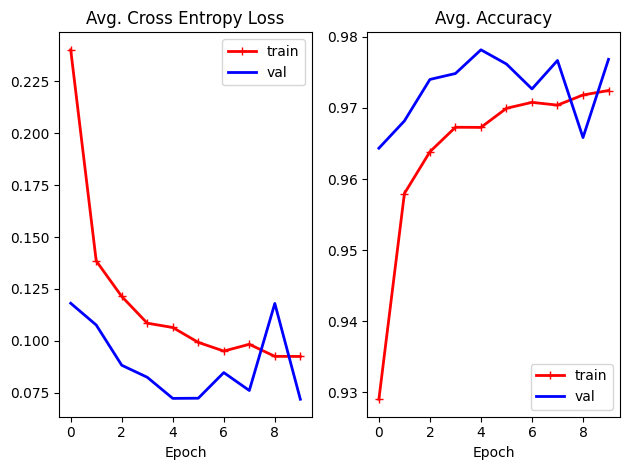

In [50]:
# Plot Learning curves
fig, ax = plt.subplots(nrows=1, ncols=2,sharex=False, sharey=False)
ax = ax.flatten()
tr_errors = [tr_avgLoss_list, tr_accuracy_list]
dev_errors = [dev_avgLoss_list, dev_accuracy_list]
er_title = ['Avg. Cross Entropy Loss','Avg. Accuracy']
for i in range(2):
    ax[i].plot(tr_errors[i],"r-+",linewidth=2, label ="train")
    ax[i].plot(dev_errors[i],"b-",linewidth=2,label ="val")
    ax[i].legend()
    ax[i].title.set_text(er_title[i])
    ax[i].set_xlabel('Epoch')

plt.tight_layout()
plt.show()

Outcomes (1) discussion: As the number of epochs increases, the average cross entropy loss decreases for both the training and validation data, but even more so for the validation data. Furthermore, as the number of epochs increases, the average accuracy increases for both the training and validation data, but even more so for the validation data. This differs from the baseline and max pooling models likely due to dropout where dropout can make learning a bit harder during training. By the last epoch (epoch 10), the baseline model still has the best training, validation, and test accuracy thus far compared to the max pooling and dropout (0.25) models. Additionally, by the last epoch (epoch 10), the baseline model also still has the best training, validation, and test loss compared to the max pooling and dropout (0.25) models.

In [51]:
# Outcomes (2): Test this baseline system with the testing data and report the
# accuracy and show a confusion matrix.

actuals = []
predicted = []

test_total_loss=0.0
test_num_correct =0
with torch.set_grad_enabled(False):
    dnn_model.eval()

    for local_batch, local_labels in testing_gen:

            local_batch = local_batch.float()
            local_labels = local_labels.float()
            local_batch, local_labels = Variable(local_batch), Variable(local_labels)

            # Model computations
            out1 = dnn_model(local_batch)
            predictions = torch.argmax(out1, dim=1)
            predicted.extend(predictions.detach().numpy())
            actuals.extend(local_labels.detach().numpy())

            #CrossEntropy loss calculation
            pLoss = loss(out1,local_labels.long())
            test_total_loss += pLoss*1 #Correct for average based on batch size

            sel_class = torch.argmax(out1,dim=1)

            test_num_correct += sel_class.eq(local_labels.long()).sum().item() #Added .long()
            test_num_samples = len(testing_gen.dataset)

    test_avgLoss = test_total_loss/len(testing_gen.dataset)
    test_accuracy = test_num_correct/test_num_samples

    print('Test Loss: {:>.9f}, Test Accuracy: {:>.5f}'.format(test_avgLoss,test_accuracy))
    print(confusion_matrix(actuals, predicted))


Test Loss: 0.004369060, Test Accuracy: 0.97910
[[ 969    0    2    0    0    3    3    0    3    0]
 [   0 1124    7    0    1    0    2    0    1    0]
 [   1    1 1015    2    1    0    1   10    1    0]
 [   0    0    4  996    0    8    0    1    1    0]
 [   1    3    4    0  965    0    1    0    3    5]
 [   0    0    1    4    0  881    2    0    4    0]
 [   8    3    2    0    4    5  935    0    1    0]
 [   0    4   14    3    1    0    0  992    3   11]
 [   4    0    6    2    0    2    3    1  953    3]
 [   3    3    1    3   12    6    0    8   12  961]]


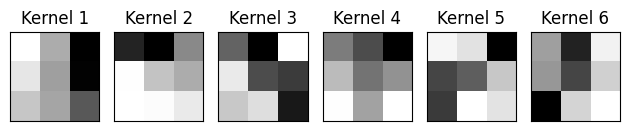

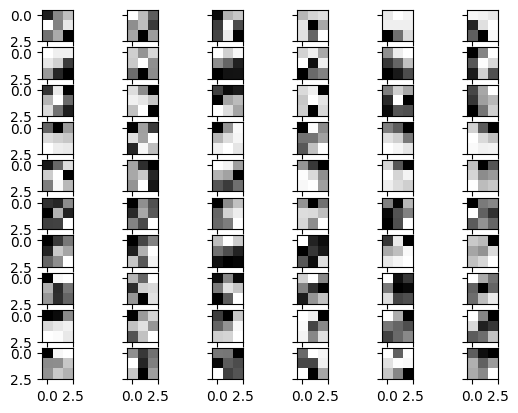

In [52]:
# Outcomes (3): Display a subset of the kernels from each convolutional layer as
# images (e.g. using matplotlib, subplot, imshow).

# Convolutional layer 1:
weights1 = dnn_model.conv1.weight.data.numpy()
filters1 = weights1.shape[0]

fig, ax = plt.subplots(nrows=1, ncols=filters1,sharex=True, sharey=True)
ax = ax.flatten()
for i in range(filters1):
    img = weights1[i].reshape(3,3)
    ax[i].imshow(img,cmap='Grays')
    ax[i].set_title(f'Kernel {i+1}')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

# Convolutional layer 2:
weights2 = dnn_model.conv2.weight.data.numpy()
filters2 = weights2.shape[0]
channels2 = weights2.shape[1]

fig, ax = plt.subplots(nrows = filters2, ncols=channels2,sharex=True, sharey=True)
ax = ax.flatten()
for i in range(filters2):
    for j in range(channels2):
        img = weights2[i,j].reshape(3,3)
        ax[i*channels2+j].imshow(img,cmap='Grays')


Outcome (3) Discussion:

I again do not see any patterns or relatinshops amonst these kernels.

Kernel 1 is interesting with the flow of light to dark from the left most column to the right most column. This is likely a type of gradient filter and again, some type of edge detection is likely being performed with this kernel.

In [53]:
# DROPOUT = 0.5
class DNN(nn.Module):
    def __init__(self):
        super(DNN,self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 3, stride = 1) # Convolutional layer 1 with 6 3x3 kernels and stride = 1
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 10, kernel_size = 3, stride = 1) # Convolutional layer 2 with 10 3x3 kernels and stride = 1
        self.dropout = nn.Dropout(0.5) # Dropout with a rate of 0.5
        new_dimension = 10 * 24 * 24 # Dimension after convolution and dropout
        self.output = nn.Linear(new_dimension, 10) # 10 neurons for the output layer

    def forward(self,sig):
        sig = self.conv1(sig) # Convolution 1
        sig = F.relu(sig) # Followed by ReLU A.F.
        sig = self.dropout(sig) # Dropout
        sig = self.conv2(sig) # Convolution 2
        sig = F.relu(sig) # Followed by ReLU A.F.
        sig = self.dropout(sig) # Dropout
        sig = sig.view(sig.size(0),-1) # Flattening
        sig = self.output(sig) # nn.Linear
        return sig

In [54]:
# Create DNN and define loss function
dnn_model = DNN()
optimizer = torch.optim.SGD(dnn_model.parameters(), lr=hyperparam.lr)
# Cross-entropy loss function
loss = nn.CrossEntropyLoss()

In [55]:
# Baseline system should use Xavier initialization based on uniform distribution
def xavier(module_weights):
    if isinstance(module_weights, (nn.Conv2d, nn.Linear)):
        torch.nn.init.xavier_uniform_(module_weights.weight)
dnn_model.apply(xavier)

DNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 10, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (output): Linear(in_features=5760, out_features=10, bias=True)
)

In [26]:
# Mini-batch GD with momentum (beta = 0.9) & mini batch size of 50
optimizer = torch.optim.SGD(dnn_model.parameters(), lr=0.05, momentum=0.9)
# A learning rate scheduler to adjust the learning rate by 10% every 10 epochs, starting with a learning rate of 0.05
learning_rate = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

In [56]:
# Early stopping
epoch_step = 10
best_dev_loss = 0
early_stop = 0

In [57]:
# Train the DNN
import warnings
warnings.filterwarnings('ignore')
tr_avgLoss_list = [] # Avg. training loss per epoch
tr_accuracy_list = [] # Training accuracy per epoch
dev_avgLoss_list = [] # Avg. validation loss per epoch
dev_accuracy_list = [] # Validation accuarcy per epoch

# Loop over epochs
for epoch in range(hyperparam.num_epochs):
    tr_num_correct = 0 # Num. correctly classified training samples
    tr_num_samples = 0 # Total number of training samples
    tr_total_loss = 0.0 # Total training loss

    dev_num_correct = 0 # Num. correctly classified validation samples
    dev_num_samples = 0 # Total number of validation samples
    dev_total_loss = 0.0 # Total validaton loss

    # Training
    dnn_model.train(True)

    with torch.set_grad_enabled(True):
        for local_batch, local_labels in training_gen:

            optimizer.zero_grad()

            local_batch = local_batch.float()
            local_labels = local_labels.float()
            local_batch, local_labels = Variable(local_batch), Variable(local_labels)

            # Model computations
            out1 = dnn_model(local_batch)
            #CrossEntropy loss calculation
            pLoss = loss(out1,local_labels.long())
            tr_total_loss += pLoss.item()*hyperparam.bs #Correct for average based on batch size

            # Backpropagation
            pLoss.backward() #gradient calculation
            optimizer.step() #weight update


            sel_class = torch.argmax(out1,dim=1)

            tr_num_correct += sel_class.eq(local_labels).sum().item()
            tr_num_samples += hyperparam.bs

        tr_avgLoss = tr_total_loss/len(training_gen.dataset)
        tr_avgLoss_list.append(tr_avgLoss)

        tr_accuracy = tr_num_correct/tr_num_samples
        tr_accuracy_list.append(tr_accuracy)

    # Validation
    with torch.set_grad_enabled(False):
        dnn_model.eval()

        for local_batch, local_labels in dev_gen:

            local_batch = local_batch.float()
            local_labels = local_labels.float()
            local_batch, local_labels = Variable(local_batch), Variable(local_labels)

            # Model computations
            out1 = dnn_model(local_batch)

            #CrossEntropy loss calculation
            pLoss = loss(out1,local_labels.long())
            dev_total_loss += pLoss*hyperparam.bs #Correct for average based on batch size

            sel_class = torch.argmax(out1,dim=1)

            dev_num_correct += sel_class.eq(local_labels).sum().item()
            #print(correction)
            dev_num_samples += hyperparam.bs

        dev_avgLoss = dev_total_loss/len(dev_gen.dataset)
        dev_avgLoss_list.append(dev_avgLoss)

        dev_accuracy = dev_num_correct/dev_num_samples
        dev_accuracy_list.append(dev_accuracy)

        learning_rate.step()

        print('Epoch {:2}, Train Loss: {:>.9f}, Train Accuracy: {:>.5f}, Dev Loss: {:>.9f}, Dev Accuracy: {:>.5f}'.format(epoch,tr_avgLoss,tr_accuracy,dev_avgLoss,dev_accuracy))

        if dev_avgLoss < best_dev_loss:
            best_dev_loss = dev_avgLoss
            early_stop = 0
        else:
            early_stop += 1
        if early_stop >= epoch_step:
            print(f"Early stopped at epoch {epoch +1}")
            break


Epoch  0, Train Loss: 0.374400476, Train Accuracy: 0.88202, Dev Loss: 0.125349626, Dev Accuracy: 0.96600
Epoch  1, Train Loss: 0.176146478, Train Accuracy: 0.94607, Dev Loss: 0.098526001, Dev Accuracy: 0.97050
Epoch  2, Train Loss: 0.148828500, Train Accuracy: 0.95491, Dev Loss: 0.081302084, Dev Accuracy: 0.97583
Epoch  3, Train Loss: 0.129970317, Train Accuracy: 0.95978, Dev Loss: 0.073142305, Dev Accuracy: 0.97717
Epoch  4, Train Loss: 0.119995209, Train Accuracy: 0.96252, Dev Loss: 0.066293702, Dev Accuracy: 0.98050
Epoch  5, Train Loss: 0.110489244, Train Accuracy: 0.96587, Dev Loss: 0.061667364, Dev Accuracy: 0.98317
Epoch  6, Train Loss: 0.105650259, Train Accuracy: 0.96774, Dev Loss: 0.058595125, Dev Accuracy: 0.98267
Epoch  7, Train Loss: 0.099149260, Train Accuracy: 0.96952, Dev Loss: 0.055464040, Dev Accuracy: 0.98350
Epoch  8, Train Loss: 0.096728718, Train Accuracy: 0.96976, Dev Loss: 0.058106720, Dev Accuracy: 0.98167
Epoch  9, Train Loss: 0.093427297, Train Accuracy: 0.97

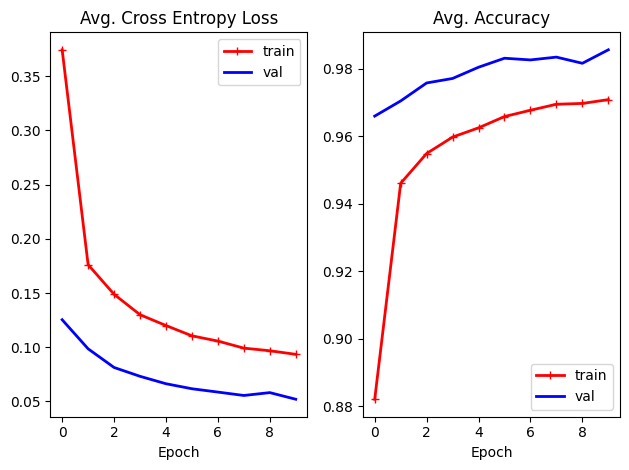

In [58]:
# Plot Learning curves
fig, ax = plt.subplots(nrows=1, ncols=2,sharex=False, sharey=False)
ax = ax.flatten()
tr_errors = [tr_avgLoss_list, tr_accuracy_list]
dev_errors = [dev_avgLoss_list, dev_accuracy_list]
er_title = ['Avg. Cross Entropy Loss','Avg. Accuracy']
for i in range(2):
    ax[i].plot(tr_errors[i],"r-+",linewidth=2, label ="train")
    ax[i].plot(dev_errors[i],"b-",linewidth=2,label ="val")
    ax[i].legend()
    ax[i].title.set_text(er_title[i])
    ax[i].set_xlabel('Epoch')

plt.tight_layout()
plt.show()

Outcomes (1) Discussion: As the number of epochs increases, the average cross entropy loss decreases for both the training and validation data, but even more so for the validation data, and both plateau a bit. Furthermore, as the number of epochs increases, the average accuracy increases for both the training and validation data, but even more so for the validation data. This differs from the baseline and max pooling models likely due to dropout where dropout can make learning a bit harder during training. The training, validation, and testing accuracies and losses here with dropout (0.5) are very close to the training, validation, and testing accuracies and losses of the dropout (0.25) model. To be specific, though, the test accuracy of the dropout (0.5) model is slightly higher than the test accuracy of the dropoout (0.25) model by the last epoch, and the loss is slightly lesser for the dropout (0.5) model.

In [59]:
# Outcomes (2): Test this baseline system with the testing data and report the
# accuracy and show a confusion matrix.

actuals = []
predicted = []

test_total_loss=0.0
test_num_correct =0
with torch.set_grad_enabled(False):
    dnn_model.eval()

    for local_batch, local_labels in testing_gen:

            local_batch = local_batch.float()
            local_labels = local_labels.float()
            local_batch, local_labels = Variable(local_batch), Variable(local_labels)

            # Model computations
            out1 = dnn_model(local_batch)
            predictions = torch.argmax(out1, dim=1)
            predicted.extend(predictions.detach().numpy())
            actuals.extend(local_labels.detach().numpy())

            #CrossEntropy loss calculation
            pLoss = loss(out1,local_labels.long())
            test_total_loss += pLoss*1 #Correct for average based on batch size

            sel_class = torch.argmax(out1,dim=1)

            test_num_correct += sel_class.eq(local_labels.long()).sum().item() #Added .long()
            test_num_samples = len(testing_gen.dataset)

    test_avgLoss = test_total_loss/len(testing_gen.dataset)
    test_accuracy = test_num_correct/test_num_samples

    print('Test Loss: {:>.9f}, Test Accuracy: {:>.5f}'.format(test_avgLoss,test_accuracy))
    print(confusion_matrix(actuals, predicted))


Test Loss: 0.003140874, Test Accuracy: 0.98440
[[ 975    0    1    0    0    0    1    1    2    0]
 [   0 1128    3    2    0    0    2    0    0    0]
 [   4    3 1009    2    1    0    2    7    4    0]
 [   0    0    3  999    0    3    0    3    2    0]
 [   1    0    0    0  974    0    2    0    2    3]
 [   2    0    0    8    0  877    2    1    2    0]
 [   7    3    0    1    1    1  941    0    4    0]
 [   1    3   10    3    0    0    0 1007    3    1]
 [   4    0    2    0    1    0    2    2  960    3]
 [   4    5    0    1    9    3    0    8    5  974]]


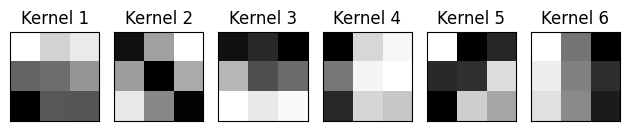

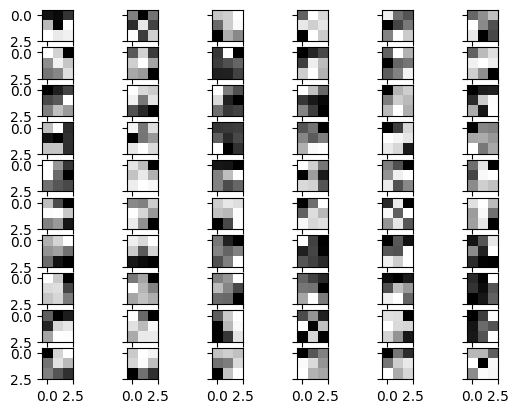

In [60]:
# Outcomes (3): Display a subset of the kernels from each convolutional layer as
# images (e.g. using matplotlib, subplot, imshow).

# Convolutional layer 1:
weights1 = dnn_model.conv1.weight.data.numpy()
filters1 = weights1.shape[0]

fig, ax = plt.subplots(nrows=1, ncols=filters1,sharex=True, sharey=True)
ax = ax.flatten()
for i in range(filters1):
    img = weights1[i].reshape(3,3)
    ax[i].imshow(img,cmap='Grays')
    ax[i].set_title(f'Kernel {i+1}')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

# Convolutional layer 2:
weights2 = dnn_model.conv2.weight.data.numpy()
filters2 = weights2.shape[0]
channels2 = weights2.shape[1]

fig, ax = plt.subplots(nrows = filters2, ncols=channels2,sharex=True, sharey=True)
ax = ax.flatten()
for i in range(filters2):
    for j in range(channels2):
        img = weights2[i,j].reshape(3,3)
        ax[i*channels2+j].imshow(img,cmap='Grays')


Outcome (3) Discussion:

Again, I do not see relationships amongst all of the kernels, but Kernel 6 is very similar to Kernel 1 of the Dropout (0.25) model. Furthermore, Kernel 4 here is essentially the opposite of Kernel 6. Kernel 3 is similar to Kernels 4 and 6 but row wise instead of column wise. Kernel 2 is also interesting as edge detection is likely being performed along the diagnol.

In [61]:
# DROPOUT = 0.75
class DNN(nn.Module):
    def __init__(self):
        super(DNN,self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 3, stride = 1) # Convolutional layer 1 with 6 3x3 kernels and stride = 1
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 10, kernel_size = 3, stride = 1) # Convolutional layer 2 with 10 3x3 kernels and stride = 1
        self.dropout = nn.Dropout(0.75) # Dropout with a rate of 0.5
        new_dimension = 10 * 24 * 24 # Dimension after convolution and dropout
        self.output = nn.Linear(new_dimension, 10) # 10 neurons for the output layer

    def forward(self,sig):
        sig = self.conv1(sig) # Convolution 1
        sig = F.relu(sig) # Followed by ReLU A.F.
        sig = self.dropout(sig) # Dropout
        sig = self.conv2(sig) # Convolution 2
        sig = F.relu(sig) # Followed by ReLU A.F.
        sig = self.dropout(sig) # Dropout
        sig = sig.view(sig.size(0),-1) # Flattening
        sig = self.output(sig) # nn.Linear
        return sig

In [62]:
# Baseline system should use Xavier initialization based on uniform distribution
def xavier(module_weights):
    if isinstance(module_weights, (nn.Conv2d, nn.Linear)):
        torch.nn.init.xavier_uniform_(module_weights.weight)
dnn_model.apply(xavier)

DNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 10, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (output): Linear(in_features=5760, out_features=10, bias=True)
)

In [63]:
# Mini-batch GD with momentum (beta = 0.9) & mini batch size of 50
optimizer = torch.optim.SGD(dnn_model.parameters(), lr=0.05, momentum=0.9)
# A learning rate scheduler to adjust the learning rate by 10% every 10 epochs, starting with a learning rate of 0.05
learning_rate = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

In [64]:
# Early stopping
epoch_step = 10
best_dev_loss = 0
early_stop = 0

In [65]:
# Train the DNN
import warnings
warnings.filterwarnings('ignore')
tr_avgLoss_list = [] # Avg. training loss per epoch
tr_accuracy_list = [] # Training accuracy per epoch
dev_avgLoss_list = [] # Avg. validation loss per epoch
dev_accuracy_list = [] # Validation accuarcy per epoch

# Loop over epochs
for epoch in range(hyperparam.num_epochs):
    tr_num_correct = 0 # Num. correctly classified training samples
    tr_num_samples = 0 # Total number of training samples
    tr_total_loss = 0.0 # Total training loss

    dev_num_correct = 0 # Num. correctly classified validation samples
    dev_num_samples = 0 # Total number of validation samples
    dev_total_loss = 0.0 # Total validaton loss

    # Training
    dnn_model.train(True)

    with torch.set_grad_enabled(True):
        for local_batch, local_labels in training_gen:

            optimizer.zero_grad()

            local_batch = local_batch.float()
            local_labels = local_labels.float()
            local_batch, local_labels = Variable(local_batch), Variable(local_labels)

            # Model computations
            out1 = dnn_model(local_batch)
            #CrossEntropy loss calculation
            pLoss = loss(out1,local_labels.long())
            tr_total_loss += pLoss.item()*hyperparam.bs #Correct for average based on batch size

            # Backpropagation
            pLoss.backward() #gradient calculation
            optimizer.step() #weight update


            sel_class = torch.argmax(out1,dim=1)

            tr_num_correct += sel_class.eq(local_labels).sum().item()
            tr_num_samples += hyperparam.bs

        tr_avgLoss = tr_total_loss/len(training_gen.dataset)
        tr_avgLoss_list.append(tr_avgLoss)

        tr_accuracy = tr_num_correct/tr_num_samples
        tr_accuracy_list.append(tr_accuracy)

    # Validation
    with torch.set_grad_enabled(False):
        dnn_model.eval()

        for local_batch, local_labels in dev_gen:

            local_batch = local_batch.float()
            local_labels = local_labels.float()
            local_batch, local_labels = Variable(local_batch), Variable(local_labels)

            # Model computations
            out1 = dnn_model(local_batch)

            #CrossEntropy loss calculation
            pLoss = loss(out1,local_labels.long())
            dev_total_loss += pLoss*hyperparam.bs #Correct for average based on batch size

            sel_class = torch.argmax(out1,dim=1)

            dev_num_correct += sel_class.eq(local_labels).sum().item()
            #print(correction)
            dev_num_samples += hyperparam.bs

        dev_avgLoss = dev_total_loss/len(dev_gen.dataset)
        dev_avgLoss_list.append(dev_avgLoss)

        dev_accuracy = dev_num_correct/dev_num_samples
        dev_accuracy_list.append(dev_accuracy)

        learning_rate.step()

        print('Epoch {:2}, Train Loss: {:>.9f}, Train Accuracy: {:>.5f}, Dev Loss: {:>.9f}, Dev Accuracy: {:>.5f}'.format(epoch,tr_avgLoss,tr_accuracy,dev_avgLoss,dev_accuracy))

        if dev_avgLoss < best_dev_loss:
            best_dev_loss = dev_avgLoss
            early_stop = 0
        else:
            early_stop += 1
        if early_stop >= epoch_step:
            print(f"Early stopped at epoch {epoch +1}")
            break


Epoch  0, Train Loss: 0.526405516, Train Accuracy: 0.83678, Dev Loss: 0.279070973, Dev Accuracy: 0.91233
Epoch  1, Train Loss: 0.393084399, Train Accuracy: 0.88298, Dev Loss: 0.210659593, Dev Accuracy: 0.94033
Epoch  2, Train Loss: 0.349437541, Train Accuracy: 0.89769, Dev Loss: 0.206473231, Dev Accuracy: 0.93350
Epoch  3, Train Loss: 0.310320931, Train Accuracy: 0.91061, Dev Loss: 0.263525486, Dev Accuracy: 0.93483
Epoch  4, Train Loss: 0.305621255, Train Accuracy: 0.91063, Dev Loss: 0.163327977, Dev Accuracy: 0.95417
Epoch  5, Train Loss: 0.311302012, Train Accuracy: 0.90985, Dev Loss: 0.159153819, Dev Accuracy: 0.95317
Epoch  6, Train Loss: 0.323301050, Train Accuracy: 0.90854, Dev Loss: 0.193957746, Dev Accuracy: 0.94350
Epoch  7, Train Loss: 0.302153267, Train Accuracy: 0.91450, Dev Loss: 0.290952563, Dev Accuracy: 0.91817
Epoch  8, Train Loss: 0.384833673, Train Accuracy: 0.88807, Dev Loss: 0.198216632, Dev Accuracy: 0.94017
Epoch  9, Train Loss: 0.313673476, Train Accuracy: 0.90

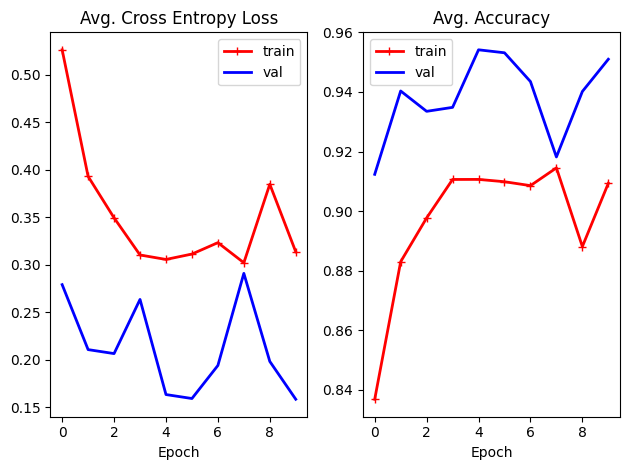

In [66]:
# Plot Learning curves
fig, ax = plt.subplots(nrows=1, ncols=2,sharex=False, sharey=False)
ax = ax.flatten()
tr_errors = [tr_avgLoss_list, tr_accuracy_list]
dev_errors = [dev_avgLoss_list, dev_accuracy_list]
er_title = ['Avg. Cross Entropy Loss','Avg. Accuracy']
for i in range(2):
    ax[i].plot(tr_errors[i],"r-+",linewidth=2, label ="train")
    ax[i].plot(dev_errors[i],"b-",linewidth=2,label ="val")
    ax[i].legend()
    ax[i].title.set_text(er_title[i])
    ax[i].set_xlabel('Epoch')

plt.tight_layout()
plt.show()

Outcomes (1) Discussion: Here, we do not see as much linear increase/decrease for the average accuracy/average cross entropy loss plots, respectively, compared to the other models. While we see similar results to the other two dropout models with the validation loss being less than the training loss and the validation accuracy being higher than the training accuracy, the training, validation, and testing accuracies at the last epoch are the lowest out of all of the models I have used. Furthermore, the training, validation, and testing losses at the last epoch are the highest out of all of the models I have used. This could be because the dropout rate of 0.75 is too high for the model and is leading to poorer performance on the training, validation, and testing data.

In [67]:
# Outcomes (2): Test this baseline system with the testing data and report the
# accuracy and show a confusion matrix.

actuals = []
predicted = []

test_total_loss=0.0
test_num_correct =0
with torch.set_grad_enabled(False):
    dnn_model.eval()

    for local_batch, local_labels in testing_gen:

            local_batch = local_batch.float()
            local_labels = local_labels.float()
            local_batch, local_labels = Variable(local_batch), Variable(local_labels)

            # Model computations
            out1 = dnn_model(local_batch)
            predictions = torch.argmax(out1, dim=1)
            predicted.extend(predictions.detach().numpy())
            actuals.extend(local_labels.detach().numpy())

            #CrossEntropy loss calculation
            pLoss = loss(out1,local_labels.long())
            test_total_loss += pLoss*1 #Correct for average based on batch size

            sel_class = torch.argmax(out1,dim=1)

            test_num_correct += sel_class.eq(local_labels.long()).sum().item() #Added .long()
            test_num_samples = len(testing_gen.dataset)

    test_avgLoss = test_total_loss/len(testing_gen.dataset)
    test_accuracy = test_num_correct/test_num_samples

    print('Test Loss: {:>.9f}, Test Accuracy: {:>.5f}'.format(test_avgLoss,test_accuracy))
    print(confusion_matrix(actuals, predicted))


Test Loss: 0.009836060, Test Accuracy: 0.95370
[[ 965    1    1    1    0    1    6    3    1    1]
 [   0 1124    4    0    0    0    2    0    5    0]
 [   3   13  983    8    5    0    2    8    9    1]
 [   1   11    8  956    0   18    0    8    5    3]
 [   0    5    3    0  947    0    5    0    2   20]
 [   3    1    0    7    0  874    5    1    0    1]
 [   8    9    3    0    2   16  919    1    0    0]
 [   0   17   16    7    1    1    0  970    3   13]
 [   3   23    9   18    7   29    7   11  857   10]
 [   5   14    2    7   13    4    0   16    6  942]]


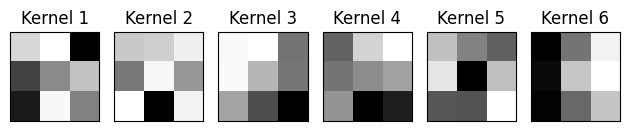

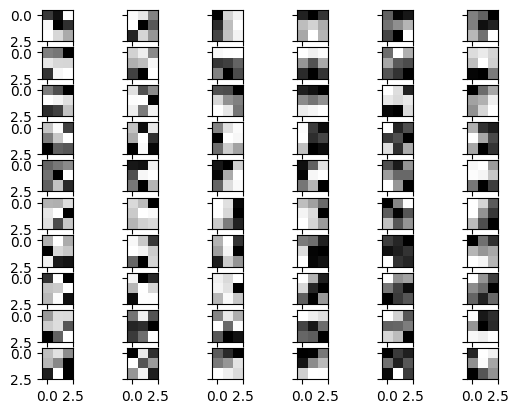

In [68]:
# Outcomes (3): Display a subset of the kernels from each convolutional layer as
# images (e.g. using matplotlib, subplot, imshow).

# Convolutional layer 1:
weights1 = dnn_model.conv1.weight.data.numpy()
filters1 = weights1.shape[0]

fig, ax = plt.subplots(nrows=1, ncols=filters1,sharex=True, sharey=True)
ax = ax.flatten()
for i in range(filters1):
    img = weights1[i].reshape(3,3)
    ax[i].imshow(img,cmap='Grays')
    ax[i].set_title(f'Kernel {i+1}')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

# Convolutional layer 2:
weights2 = dnn_model.conv2.weight.data.numpy()
filters2 = weights2.shape[0]
channels2 = weights2.shape[1]

fig, ax = plt.subplots(nrows = filters2, ncols=channels2,sharex=True, sharey=True)
ax = ax.flatten()
for i in range(filters2):
    for j in range(channels2):
        img = weights2[i,j].reshape(3,3)
        ax[i*channels2+j].imshow(img,cmap='Grays')


Outcome (3) Discussion:

Again, I do not see any patterns or relationships amongst all of the kernels, but Kernel 6 is again doing the flow from dark to light from the right column of the kernel to the left column of the kernel.

Overall, in interpreting these kernels, I know they all have a certain purpose and are performing feature detection in various ways.